## Customs Channel Model Training

This notebook presents the experiments of end-to-end training and evaluation of machine learning models developed to predict customs clearance channels based on import declaration data. The workflow includes data preparation, categorical feature encoding, handling of severe class imbalance through hybrid resampling strategies, and model training using both Logistic Regression and Random Forest classifiers. Each step is followed by a detailed analysis of the models’ performance, feature importances, and their ability to capture minority classes. The final section discusses insights and potential improvements for future iterations.

## Table of Contents

1. [Initial Data Preparation](#initial-data-preparation)

2. [Prepare Data for Training](#prepare-data-for-training)

3. [Logistic Regression Without Resampling](#logistic-regression-without-resampling)

4. [Logistic Regression with Hybrid Resampling Approach](#logistic-regression-with-hybrid-resampling-approach)

5. [Logistic Regression Feature Importances](#logistic-regression-feature-importances)

6. [Random Forest Without Resampling](#random-forest-without-resampling)

7. [Random Forest with Hybrid Resampling Approach](#random-forest-with-hybrid-resampling-approach)

8. [Random Forest Feature Importances](#random-forest-feature-importances)

9. [Conclusion](#conclusion)


### Initial Data Preparation  

In [1]:
# Import libraries
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import my_functions
import warnings
import joblib
warnings.filterwarnings("ignore")

In [2]:
# Load data
df = pd.read_csv("data/data_for_model.csv",sep=';')


In [3]:
df.shape

(100000, 30)

In [4]:
# Display first 10 rows
df.head(10)

,document_number,clearance_place_dispatch,clearance_place_entry,consignee_code,consignee_company_size,clearance_place,transport_mode_pt,ncm_code,shipper_name,country_origin_code,...,country_red_risk,country_gray_risk,importer_red_risk,importer_gray_risk,lag1_ncm_red_ratio,lag1_ncm_gray_ratio,lag1_country_red_ratio,lag1_country_gray_ratio,lag1_channel_importer,ncm_chapter
0,DI001000000,AEROPORTO DE VIRACOPOS,PORTO DE PARANAGUÁ,96582710910444,DEMAIS,BRASIL TERMINAL PORTUÁRIO LTDA,MARITIMA,85444200,DISTRIBUIDORA PEREIRA S/A,116,...,0.017214,0.000000,0.017588,0.000000,0.016393,0.0,0.008197,0.0,VERDE,85
1,DI001000001,PORTO DE ITAJAÍ,AEROPORTO DE BRASÍLIA,11076095431713,DEMAIS,PORTO DE ITAJAÍ - AUTORIDADE PORTUÁRIA,MARITIMA,29362700,INTERNATIONAL LOPES IMP EXP LTDA,218,...,0.020665,0.001292,0.011905,0.000000,0.042553,0.0,0.017647,0.0,VERDE,29
2,DI001000002,AEROPORTO DE VIRACOPOS,AEROPORTO DE VIRACOPOS,89649666811829,DEMAIS,AEROPORTOS BRASIL - VIRACOPOS S/A,MARITIMA,85171200,INTERNATIONAL LOPES LTDA ME,97,...,0.024804,0.000653,0.018163,0.001048,0.000000,0.0,0.045455,0.0,VERDE,85
3,DI001000003,PORTO DE SANTOS,PORTO DE SANTOS,71804559128933,DEMAIS,PORTO DE ITAJAÍ - AUTORIDADE PORTUÁRIA,AEREA,85444200,NACIONAL PEREIRA LTDA,97,...,0.024804,0.000653,0.060606,0.000000,0.007246,0.0,0.020408,0.0,VERDE,85
4,DI001000004,PORTO DE ITAJAÍ,PORTO DE SUAPE,25639427881692,DEMAIS,TCP - TERMINAL DE CONTEINERES DE PARANAGUA S/A,AEREA,29362600,COMERCIAL MONTEIRO EIRELI,169,...,0.022014,0.000324,0.024000,0.000000,0.016667,0.0,0.008621,0.0,VERDE,29
5,DI001000005,PORTO DE SANTOS,AEROPORTO DE VIRACOPOS,36748675675362,DEMAIS,CONCESSIONÁRIA DO AEROPORTO INTERNACIONAL DE G...,MARITIMA,87060010,GLOBAL SANTOS EIRELI,246,...,0.016414,0.000316,0.020146,0.000298,0.009615,0.0,0.008696,0.0,VERDE,87
6,DI001000006,AEROPORTO DE BRASÍLIA,AEROPORTO DE VIRACOPOS,15952859947558,DEMAIS,CONCESSIONÁRIA DO AEROPORTO INTERNACIONAL DE G...,MARITIMA,73182900,BRASIL VIEIRA IMP EXP LTDA,756,...,0.024242,0.000319,0.000000,0.000000,0.012658,0.0,0.010753,0.0,VERDE,73
7,DI001000007,PORTO DE SUAPE,PORTO DE PARANAGUÁ,57795001732538,DEMAIS,CONCESSIONÁRIA DO AEROPORTO INTERNACIONAL DE G...,AEREA,30049099,LOGÍSTICA SOARES S/A,372,...,0.021392,0.000639,0.000000,0.000000,0.000000,0.0,0.018692,0.0,VERDE,30
8,DI001000008,PORTO DE SANTOS,AEROPORTO DE CONGONHAS,28745271936700,DEMAIS,LIBRA TERMINAIS SANTOS S/A,RODOVIARIA,87060010,DISTRIBUIDORA MENDES COMERCIO LTDA,169,...,0.022014,0.000324,0.023591,0.001311,0.016304,0.0,0.026490,0.0,VERDE,87
9,DI001000009,AEROPORTO DE CONGONHAS,PORTO DE SALVADOR,84219933083353,DEMAIS,INST. PORTUARIA PUBLICA - SANTOS BRASIL PARTIC...,MARITIMA,85171200,COMERCIAL MENDES LTDA ME,756,...,0.024242,0.000319,0.041322,0.000000,0.017045,0.0,0.012903,0.0,VERDE,85


In [5]:
# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   document_number           100000 non-null  object 
 1   clearance_place_dispatch  100000 non-null  object 
 2   clearance_place_entry     100000 non-null  object 
 3   consignee_code            100000 non-null  int64  
 4   consignee_company_size    100000 non-null  object 
 5   clearance_place           100000 non-null  object 
 6   transport_mode_pt         100000 non-null  object 
 7   ncm_code                  100000 non-null  object 
 8   shipper_name              100000 non-null  object 
 9   country_origin_code       100000 non-null  object 
 10  channel                   100000 non-null  object 
 11  year                      100000 non-null  int64  
 12  month                     100000 non-null  int64  
 13  day                       100000 non-null  in

In [6]:
# Drop document_number column as it is an identifier
df = df.drop(columns=['document_number'])

In [7]:
# Convert 'consignee_code' to categorical
df['consignee_code'] = df['consignee_code'].astype('category')

In [8]:
# Convert object-type categorical columns to category dtype for memory efficiency
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].astype('category')

In [9]:
# Target variable class imbalance
print(df['channel'].value_counts())

channel
VERDE       97016
VERMELHO     2071
AMARELO       866
CINZA          47
Name: count, dtype: int64


### Prepare data for training

In [10]:
# TIME-BASED TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = my_functions.time_based_train_test_split(df)

Train period: 2023-01-01 00:00:00 -> 2024-05-28 00:00:00
Test period:  2024-05-28 00:00:00 -> 2025-01-31 00:00:00


In [11]:
# FEATURE ENGINEERING OF CATEGORICAL FEATURES
X_train, X_test, final_feature_names, preprocessor = my_functions.prepare_categorical_features(X_train, X_test)

High-cardinality columns detected: ['consignee_code', 'shipper_name']
Train shape: (70000, 149)
Test shape:  (30000, 149)
Features length: 149


In [12]:
# TRANSFORM CATEGORICAL LABEL INTO INTEGER
y_train, y_test = my_functions.encode_target(y_train, y_test)


Encoded class distribution:
Train:
 {0: 67911, 1: 1432, 2: 626, 3: 31}
Test:
 {0: 29105, 1: 639, 2: 240, 3: 16}


### Logistic Regression Without Resampling

First, I will try a simpler model and address the class imbalance using the model’s built-in functionality by setting class_weight='balanced', which gives higher importance to minority classes. Additionally, the model performance will be also evaluated with macro F1 and balanced accuracy metrics to ensure fair assessment across all classes.

In [13]:
# SCALE NUMERICAL FEATURES FOR LOGISTIC REGRESSION
X_train_scaled, X_test_scaled = my_functions.scale_numerical_features(X_train, X_test, feature_names=final_feature_names)

Scaled 18 numerical features.


In [ ]:
# MODEL TRAINING
# Initialize logistic regression model
logreg = LogisticRegression(
    random_state=42,
    max_iter=1000,         # Ensure convergence
    n_jobs=2,
    penalty='l2',          # L2 regularization
    solver='lbfgs',        # Suitable for multiclass
    class_weight='balanced'  # Handle class imbalance
)

# Fit logistic regression to the scaled training set
logreg.fit(X_train_scaled, y_train)

# Predictions on test set
y_pred_lr = logreg.predict(X_test_scaled)

# Evaluate model
metrics = my_functions.evaluate_logistic_regression(y_test, y_pred_lr)

--- LOGISTIC REGRESSION RESULTS ---

CONFUSION MATRIX:
[[12734  4469 10737  1165]
 [  181   286   149    23]
 [  107    38    89     6]
 [    7     0     5     4]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.98      0.44      0.60     29105
           1       0.06      0.45      0.11       639
           2       0.01      0.37      0.02       240
           3       0.00      0.25      0.01        16

    accuracy                           0.44     30000
   macro avg       0.26      0.38      0.18     30000
weighted avg       0.95      0.44      0.59     30000


Accuracy: 0.4371
Macro F1: 0.1831
Balanced Accuracy: 0.3765


**Analysis:** This logistic regression model with class_weight='balanced' provides a baseline for handling the extreme class imbalance. It shows that minority classes receive attention, achieving some recall for underrepresented classes, but overall performance remains low, with a macro F1 score of 0.18 and balanced accuracy of 0.38. Most samples from classes 1, 2, and 3 are still misclassified, suggesting that further strategies, such as resampling methods, might be necessary to improve the results.

In [ ]:
# Save model
joblib_file = "all_models/logreg.pkl"
joblib.dump(logreg, joblib_file)
print(f"Model saved to {joblib_file}")

Model saved to all_models/logreg.pkl


### Logistic Regression with hybrid resampling approach

To further address the class imbalance I will try a resampling approach before fitting the model. This approach undersamples the majority class to match the number of samples of the second-largest class (VERMELHO) and oversamples the remaining minority classes until they also reach the same size as VERMELHO. I chose this hybrid approach to mitigate the potential negative effects of excessive undersampling and oversampling while balancing the dataset. Given the extreme class imbalance, straightforward oversampling would generate an excessive number of synthetic samples, which could introduce noise and overfit the model, while undersampling would discard a large portion of valuable data.

In [ ]:
# MODEL TRAINING
# Define resamplers
over = SMOTE(sampling_strategy={2: 1432, 3: 1432}, random_state=42)
under = RandomUnderSampler(sampling_strategy={0: 1432}, random_state=42)

# Build pipeline: oversample → undersample → logistic regression
pipeline = Pipeline([
    ('over', over),
    ('under', under),
    ('clf', LogisticRegression(
        random_state=42,
        max_iter=1000,
        n_jobs=2,
        penalty='l2',
        solver='lbfgs',
        class_weight='balanced'  # keep for extra weighting
    ))
])

# Fit pipeline on scaled training data
pipeline.fit(X_train_scaled, y_train)

# Predictions on test set
y_pred_lr = pipeline.predict(X_test_scaled)

# Evaluate model
metrics = my_functions.evaluate_logistic_regression(y_test, y_pred_lr)

--- LOGISTIC REGRESSION RESULTS ---

CONFUSION MATRIX:
[[11752  4949 11361  1043]
 [  181   290   147    21]
 [   93    46    96     5]
 [    5     0     6     5]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.98      0.40      0.57     29105
           1       0.05      0.45      0.10       639
           2       0.01      0.40      0.02       240
           3       0.00      0.31      0.01        16

    accuracy                           0.40     30000
   macro avg       0.26      0.39      0.17     30000
weighted avg       0.95      0.40      0.56     30000


Accuracy: 0.4048
Macro F1: 0.1737
Balanced Accuracy: 0.3925


**Analysis:** After applying the resampling strategy, the second model shows a small improvement in the recall of the minority classes AMARELO (from 0.37 to 0.40) and CINZA (from 0.25 to 0.31). The recall of the other minority class VERMELHO remained the same (0.45) and the recall of the majority class VERDE slightly reduced (from 0.44 to 0.40). However, the overall metrics still remain low and minority classes still have very low precision and F1 scores, showing that logistic regression alone struggles to fully capture them despite the resampling. Therefore, it might be necessary to test a model with higher complexity than logistic regression.

In [ ]:
# Save model
joblib_file = "all_models/logreg_resampling.pkl"
joblib.dump(logreg, joblib_file)
print(f"Model saved to {joblib_file}")

Model saved to all_models/logreg_resampling.pkl


### Logistic Regression Feature Importances

I decided to use permutation importance to assess feature relevance for the logistic regression model because it is model-agnostic and measures the actual impact of each feature on the chosen performance metric (here, macro F1) by shuffling the feature values.

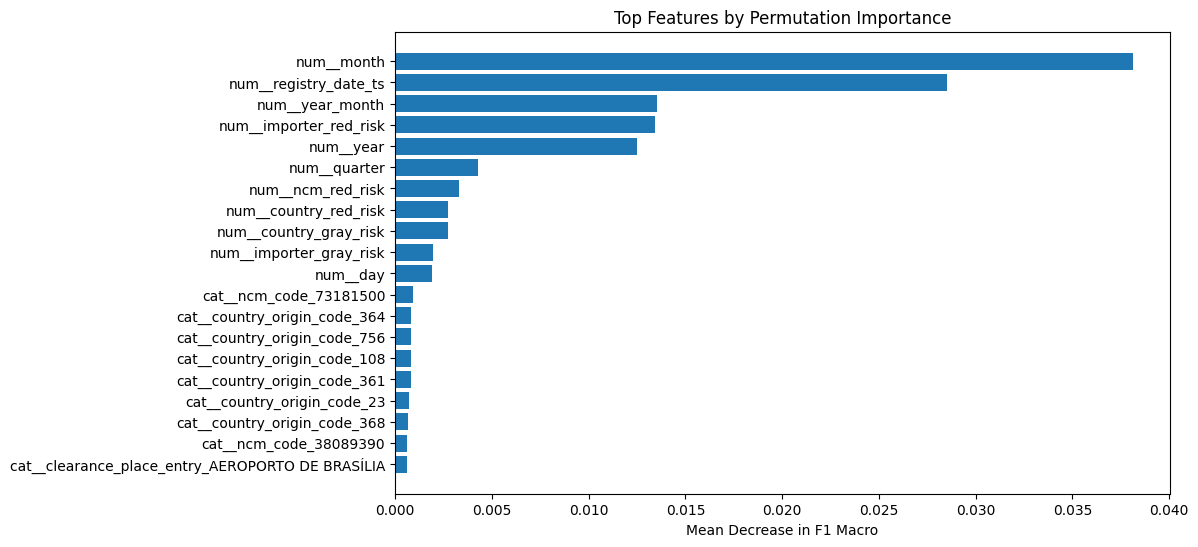

In [ ]:
# COMPUTE PERMUTATION IMPORTANCE FOR LOGISTIC REGRESSION
perm_df = my_functions.logistic_regression_permutation_importance(logreg, X_test_scaled, y_test, feature_names=final_feature_names, top_n=20)


**Analysis:** The permutation importance results show that temporal features, such as num__month, num__registry_date_ts, and num__year_month, are the most influential for the model’s predictions. Some risk-related numerical features, like num__importer_red_risk and num__ncm_red_risk, also contribute noticeably, while categorical features and other numeric indicators have a smaller impact. This indicates that time-related patterns play a major role in predicting the target variable, with other risk features providing incremental predictive power.

**Note:** In a real-world scenario, I would start by testing a decision tree after the logistic regression. However, I will proceed directly to Random Forest, as it is one of the required algorithms for this job position.

### Random Forest Without Resampling

Using the same strategy I used with logistic regression, I will first address the class imbalance using the model’s built-in functionality by setting class_weight='balanced', which gives higher importance to minority classes. In the case of Random Forest, I will also use Stratified K-Folds to maintain class distribution across folds.

In [ ]:
# MODEL TRAINING
# Initialize base model using balanced class weights to handle class imbalance
rf = RandomForestClassifier(random_state=42, class_weight='balanced') 

# Initialize Stratified K-Folds to maintain class distribution across folds
skf = StratifiedKFold(n_splits=5)

# Define the hyperparameter grid. 
# Due to time and computational constraints, the grid search is limited to three parameters with a few selected values for each.
param_grid = {
    'n_estimators': [100, 200, 300],    # Number of trees
    'max_depth': [10, 20],              # Maximum depth of the tree
    'min_samples_split': [5, 10]        # Minimum samples required to split a node
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1_macro',   # Use macro F1 to handle class imbalance
    cv=skf,               # Stratified cross-validation 
    n_jobs=2,           
    verbose=3
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [10, 20], 'min_samples_split': [5, 10], 'n_estimators': [100, 200, ...]}"
,scoring,'f1_macro'
,n_jobs,2
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [ ]:
# RETRIEVE GRID SEARCH RESULTS
best_rf, y_pred = my_functions.evaluate_search(grid_search, X_test)

# RETRIEVE MODEL PERFORMANCE METRICS
metrics = my_functions.evaluate_model_performance(y_test, y_pred)

--- GRID SEARCH RESULTS ---
Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}
Best Macro F1 Score: 0.2606

CONFUSION MATRIX:
[[27623  1469    13     0]
 [  485   154     0     0]
 [  229    11     0     0]
 [   15     1     0     0]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     29105
           1       0.09      0.24      0.14       639
           2       0.00      0.00      0.00       240
           3       0.00      0.00      0.00        16

    accuracy                           0.93     30000
   macro avg       0.27      0.30      0.27     30000
weighted avg       0.95      0.93      0.94     30000


OVERALL METRICS:
Accuracy:           0.9259
Macro F1 Score:     0.2742
Balanced Accuracy:  0.2975


**Analysis:** The Random Forest model with balanced class weights and stratified cross-validation achieved a macro F1 score of 0.2606, indicating limited effectiveness in handling the severe class imbalance in the dataset. Although the overall accuracy is high (93%), the confusion matrix and classification report reveal that the model performs well mainly for the majority class (VERDE), while struggling to correctly classify minority classes (VERMELHO, AMARELO, and CINZA). The recalls for the minority classes AMARELO and CINZA are zero and for the minority class VERMELHO the recall is 0.24. Therefore, the logistic regression model tested before is still better for classifying the minority classes. 

In [ ]:
# Save model
joblib_file = "all_models/best_rf_model.pkl"
joblib.dump(best_rf, joblib_file)
print(f"Model saved to {joblib_file}")

Model saved to all_models/best_rf_model.pkl


### Random Forest with hybrid resampling approach

To further address the class imbalance I will try the same resampling approach I used in logistic regression model. The approach undersamples the majority class to match the number of samples of the second-largest class (VERMELHO) and oversamples the remaining minority classes until they also reach the same size as VERMELHO. 

In [ ]:
# MODEL TRAINING
# Initialize base model (no class_weight)
rf = RandomForestClassifier(random_state=42)

# Define resamplers
over = SMOTE(sampling_strategy={2: 1432, 3: 1432}, random_state=42)
under = RandomUnderSampler(sampling_strategy={0: 1432}, random_state=42)

# Initialize Stratified K-Folds to maintain class distribution across folds
skf = StratifiedKFold(n_splits=5)

# Build pipeline: oversample → undersample → classifier
pipeline = Pipeline([
    ('over', over),
    ('under', under),
    ('clf', rf)
])

# Define hyperparameter grid (for the classifier inside the pipeline)
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [10, 20],
    'clf__min_samples_split': [5, 10]
}

# Grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=skf,
    n_jobs=2,
    verbose=2
)

# Fit grid search
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__max_depth': [10, 20], 'clf__min_samples_split': [5, 10], 'clf__n_estimators': [100, 200, ...]}"
,scoring,'f1_macro'
,n_jobs,2
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,sampling_strategy,"{2: 1432, 3: 1432}"


In [ ]:
# RETRIEVE GRID SEARCH RESULTS
best_rf, y_pred = my_functions.evaluate_search(grid_search, X_test)

# RETRIEVE MODEL PERFORMANCE METRICS
metrics = my_functions.evaluate_model_performance(y_test, y_pred)

--- SEARCH RESULTS ---
Best Parameters: {'clf__max_depth': 10, 'clf__min_samples_split': 10, 'clf__n_estimators': 300}
Best Macro F1 Score: 0.2676

CONFUSION MATRIX:
[[18563  9763   685    94]
 [  208   417    13     1]
 [  147    89     3     1]
 [   10     3     0     3]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.98      0.64      0.77     29105
           1       0.04      0.65      0.08       639
           2       0.00      0.01      0.01       240
           3       0.03      0.19      0.05        16

    accuracy                           0.63     30000
   macro avg       0.26      0.37      0.23     30000
weighted avg       0.95      0.63      0.75     30000


OVERALL METRICS:
Accuracy:           0.6329
Macro F1 Score:     0.2270
Balanced Accuracy:  0.3726


**Analysis:** After applying the resampling strategy, the Random Forest model shows a small improvement in the recall of the minority classes VERMELHO (from 0.24 to 0.65) and CINZA (from 0.0 to 0.19). The recall of the other minority class AMARELO remained roughly the same (from 0.0 to 0.01) and the recall of the majority class VERDE reduced (from 0.95 to 0.64). However, the Macro F1 Score and Balanced Accuracy remain low because the model still performs better for the majority class VERDE.

In [ ]:
# Save model
joblib_file = "all_models/best_rf_model_resampling.pkl"
joblib.dump(best_rf, joblib_file)
print(f"Model saved to {joblib_file}")

Model saved to all_models/best_rf_model_resampling.pkl


### Random Forest Feature Importances

Random Forest models inherently provide feature importances, which indicate how much each feature contributes to the model’s predictions. These importances are calculated based on how much each feature decreases the impurity (for example, Gini impurity) across all trees in the ensemble.

                                          feature  importance
0                         num__importer_gray_risk    0.198380
1                          num__importer_red_risk    0.067347
2                          num__country_gray_risk    0.064197
3                              num__ncm_gray_risk    0.053440
4                           num__registry_date_ts    0.021717
5                                 num__year_month    0.021073
6                    cat__transport_mode_pt_AEREA    0.020865
7                        num__consignee_code_freq    0.019810
8                                      num__month    0.019142
9                 cat__transport_mode_pt_MARITIMA    0.016516
10  cat__clearance_place_dispatch_PORTO DE ITAJAÍ    0.015541
11                              num__ncm_red_risk    0.015384
12                   cat__country_origin_code_368    0.014295
13                        num__lag1_ncm_red_ratio    0.013917
14                          num__country_red_risk    0.013094
15      

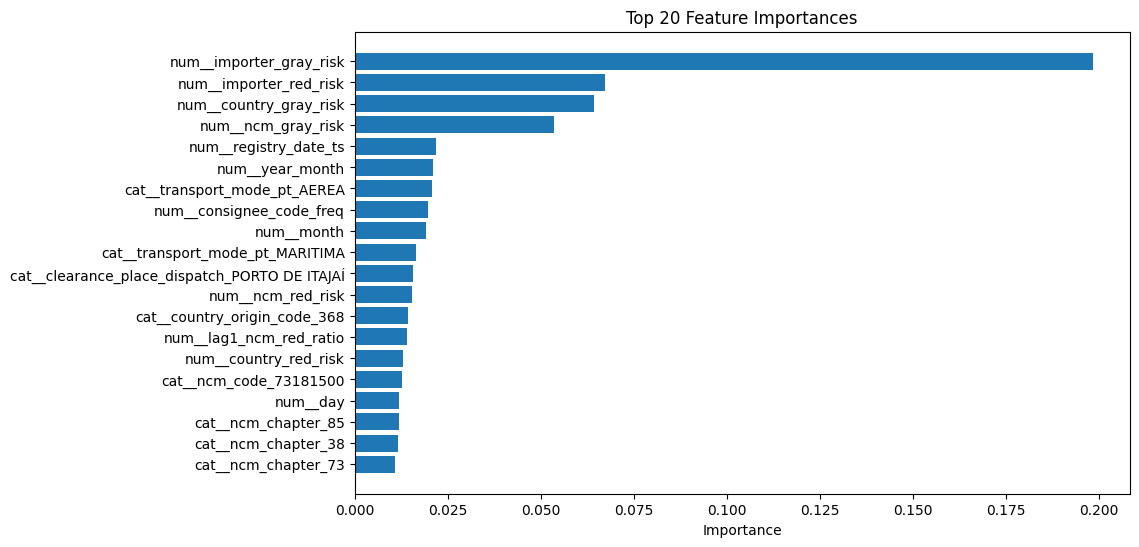

In [ ]:
# RETRIEVE RANDOM FOREST FEATURE IMPORTANCES
feature_importance_df = my_functions.plot_feature_importances(best_rf, final_feature_names, top_n=20)

**Analysis:** The feature importances indicate that the model relies most heavily on historical risk indicators, such as importer_gray_risk and importer_red_risk, followed by country- and product-level risk metrics. Temporal features like registry_date_ts and derived date components (day, year_month) also contribute meaningfully. Frequency-encoded categorical features, such as consignee_code_freq and shipper_name_freq, have moderate importance, while specific low-cardinality categorical features (e.g., transport mode or clearance place) play a minor role. Overall, the model prioritizes numeric risk-based and historical features over categorical identifiers.

### Conclusion

None of the trained models were able to classify the minority classes effectively. In future attempts, I would explore alternative under- and oversampling methods. I initially opted for a hybrid approach because the extreme class imbalance made straightforward oversampling risky, as generating too many synthetic samples could introduce noise and lead to overfitting, while just undersampling would discard a substantial amount of valuable data. Apart from trying other resampling methods, it is also possible to adjust the model's decision threshold to better favor the minority class. Additionally, some improvements could be made during preprocessing, for example applying dimensionality reduction techniques such as PCA after one-hot encoding to mitigate the curse of dimensionality, or replacing one-hot encoding with frequency encoding for most categorical variables to create a more compact feature space. I would also experiment with other machine learning models and resampling strategies tailored to business needs. For instance, one approach could be undersampling until the minority class CINZA to build a model specifically focused on detecting this higher-risk class. Another potential strategy would be to transform the problem into a binary classification by grouping the minority classes together. However, these alternative strategies would require careful evaluation to ensure alignment with the business context and the intended application of the model. 

**Model Choice:** As mentioned above, none of the trained models were able to classify the minority classes effectively. However, since I need to select one model to complete the remaining parts of this assignment, I will proceed with the Random Forest model combined with the hybrid resampling strategy, as it is one of the algorithms of particular interest for the current job position.